In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import math

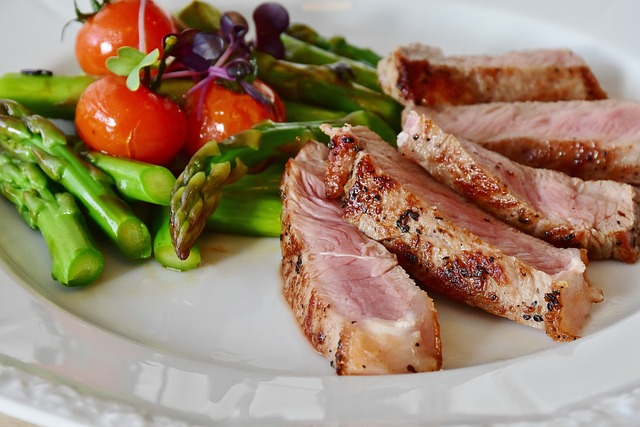

In [28]:
test_image = Image.open(r"D:\I-Jepa\src\utils\photos_no_class\asparagus-g4c4164115_640.jpg").convert("RGB")
test_image

In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize to model input size
    transforms.ToTensor(),                 # Convert to tensor (C, H, W) & normalize [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize (example values)
])

tensor_image = transform(test_image)  # Shape: [3, 224, 224]

In [30]:
tensor_image.shape

torch.Size([3, 224, 224])

In [34]:
batch_image = torch.unsqueeze(tensor_image, dim = 0)
batch_image.size()

torch.Size([1, 3, 224, 224])

In [ ]:
def image_to_patches(image_batch=batch_image, patch_size=16): #Gives output as [batch_size, number of patches, dimensions of patches]
    B, C, H, W = image_batch.shape
    assert H % patch_size == 0 and W % patch_size == 0

    num_p_h = H // patch_size
    num_p_w = W // patch_size
    N = num_p_h * num_p_w

    # 1) reshape into blocks
    x = image_batch.reshape(
        B, C,
        num_p_h, patch_size,
        num_p_w, patch_size
    )

    x = x.permute(0, 2, 4, 3, 5, 1)

    # 3) flatten each patch
    patch_dim = patch_size * patch_size * C
    patches = x.reshape(B, N, patch_dim)

    return patches

In [39]:
init_patcher = image_to_patches()
init_patcher.shape

torch.Size([1, 196, 768])

In [ ]:
class ImageEmbedding(nn.Module):
    """
    Splits an image into patches, flattens each patch, projects to latent_dim,
    and prepends a [CLS] token plus learned positional embeddings.
    """
    def __init__(self, latent_dim, patch_dim, num_patches):
        super().__init__()
        # linear projection for each flattened patch
        self.patch_to_embedding = nn.Linear(patch_dim, latent_dim)
        # single cls token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, latent_dim))
        # positional embeddings for [CLS] + every patch
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, latent_dim))

    def forward(self, x):
        # x: (B, num_patches, patch_dim)
        B, N, _ = x.shape
        # project patches => (B, N, D)
        patches = self.patch_to_embedding(x)
        # expand cls tokens => (B, 1, D)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        # concat => (B, N+1, D)
        x = torch.cat([cls_tokens, patches], dim=1)
        # add pos embeddings
        x = x + self.pos_embed
        return x

In [46]:
init_embedder = ImageEmbedding(540, init_patcher.shape[2], init_patcher.shape[1])
init_embedder.patch_to_embedding
init_embedder.cls_token.size()
init_embedder.pos_embed.size()

torch.Size([1, 197, 540])

In [49]:
init_embedder.forward(init_patcher).size()

torch.Size([1, 197, 540])

In [50]:
class Multi_head_Attention(nn.Module):
    def __init__(self, mat_dims, input_matrix, num_attention_heads, masking = False):
        super().__init__()

        self.mask = masking
        self.input_matrix = input_matrix
        self.query_mat = torch.randn([num_attention_heads,len(self.input_matrix[0]), mat_dims])
        self.key_mat = torch.randn([num_attention_heads,len(self.input_matrix[0]), mat_dims])
        self.value_mat = torch.randn([num_attention_heads,len(self.input_matrix[0]), mat_dims])
    
    def forward(self):

        Q = torch.matmul(self.input_matrix, self.query_mat)
        K = torch.matmul(self.input_matrix, self.key_mat)
        V = torch.matmul(self.input_matrix, self.value_mat)
        Q_mat_K = torch.matmul(Q, torch.transpose(K,2,1))/math.sqrt(len(self.input_matrix[0]))

        if self.mask:
            masked_mat = Q_mat_K.clone()
            mask = torch.triu(torch.ones_like(Q_mat_K), diagonal=1).bool()
            masked_mat[mask] = float('-inf')

            return (torch.softmax(masked_mat, dim=1),V)

        return (torch.softmax(Q_mat_K, dim = 1),V)
    
def max_multi_v(tensor, value_tensor):
    multip = torch.matmul(tensor,value_tensor)

    return multip

def concat_attention_heads(tensors):
    concats = torch.sum(tensors, dim = 0)

    return concats

def linear_transform_concatenated_head(tensor, matrix):
    head_mul_weights = torch.matmul(tensor, matrix)

    return head_mul_weights

def adding_normalizing(original_matrix, single_head_matrix):
    adder = torch.add(original_matrix, single_head_matrix)
    means = torch.mean(adder, dim = 1, keepdim =True)
    squared_diff = (adder - means) ** 2 
    std_dev = torch.sqrt(torch.mean(squared_diff, dim = 1, keepdim=True))
    
    normalized = (adder - means) / (std_dev + 0.0001)

    return normalized

class Feedforward(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear = nn.Linear(input_dim, output_dim, bias= True)
        self.relu = nn.ReLU()

    def forward(self, matrix):
        matrix = self.linear(matrix)

        return self.relu(matrix)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_attention_heads, ff_hidden_dim, dropout_rate=0.1):
        super().__init__()
        # Standard LayerNorm as in PyTorch
        self.norm1 = nn.LayerNorm(embed_dim)
        # Re-implementing Multi-head attention in a standard way
        # Your original Multi_head_Attention class is hard to integrate due to input_matrix in init
        # and forward method not taking input 'x'.
        # I'll use a more standard implementation for the block.
        self.attention = nn.MultiheadAttention(embed_dim, num_attention_heads, dropout=dropout_rate, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.norm2 = nn.LayerNorm(embed_dim)
        # Using a standard Feedforward (MLP) as in ViT
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden_dim),
            nn.GELU(), # GELU is standard in ViT
            nn.Dropout(dropout_rate),
            nn.Linear(ff_hidden_dim, embed_dim),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # Pre-Layer Normalization structure:
        # 1. Norm input
        # 2. Pass through sub-layer
        # 3. Add residual
        norm_x = self.norm1(x)
        # PyTorch's MultiheadAttention returns attn_output, attn_output_weights
        attn_output, _ = self.attention(norm_x, norm_x, norm_x)
        x = x + self.dropout1(attn_output) # Residual connection + Dropout

        norm_x = self.norm2(x)
        ff_output = self.feedforward(norm_x)
        x = x + ff_output # Residual connection (dropout handled within feedforward sequential)

        return x

class VisionTransformerEncoder(nn.Module):
    def __init__(self, num_layers, embed_dim, num_attention_heads, ff_dim_multiplier=4, dropout_rate=0.1):
        super().__init__()
        ff_hidden_dim = embed_dim * ff_dim_multiplier
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_attention_heads, ff_hidden_dim, dropout_rate)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim) # Final LayerNorm after all blocks

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class VisionTransformer(nn.Module):
    def __init__(self,
                 seq_len, # Number of tokens (e.g., num_patches + 1 for CLS)
                 embed_dim, # Dimension of embeddings
                 num_classes, # Number of output classes
                 num_layers, # Number of Transformer Encoder Blocks
                 num_attention_heads, # Number of heads in Multi-Head Attention
                 ff_dim_multiplier=4, # Multiplier for FF hidden dimension
                 dropout_rate=0.1):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_classes = num_classes

        # The core encoder composed of stacked TransformerEncoderBlocks
        self.encoder = VisionTransformerEncoder(
            num_layers,
            embed_dim,
            num_attention_heads,
            ff_dim_multiplier,
            dropout_rate
        )

        # The classification head (MLP Head)
        # Operates on the [CLS] token output from the encoder
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), # Optional intermediate layer
            nn.GELU(),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        # x is assumed to be the combined input embeddings:
        # (batch_size, sequence_length, embed_dim)
        # where sequence_length includes the [CLS] token and all patch tokens.

        # Pass through the Transformer Encoder stack
        encoded_features = self.encoder(x) # (batch_size, seq_len, embed_dim)

        # Extract the output of the [CLS] token for classification
        # The [CLS] token is typically the first token in the sequence (index 0)
        cls_token_output = encoded_features[:, 0, :] # (batch_size, embed_dim)

        # Pass the [CLS] token output through the MLP head for final classification
        logits = self.mlp_head(cls_token_output)

        return logits

In [51]:
init_attention = Multi_head_Attention(4,torch.randn((3,6)),10,True)
tensor, value_tensor = init_attention.forward()
print("Original Multi_head_Attention output (tensor):", tensor.shape)
print("Original Multi_head_Attention output (value_tensor):", value_tensor.shape)

mul = max_multi_v(tensor, value_tensor)
print("max_multi_v output shape:", mul.size())

con = concat_attention_heads(mul)
print("concat_attention_heads output shape:", con.shape)

check_add = adding_normalizing(torch.randn((3,6)), con)
print("adding_normalizing output shape (first):", check_add.shape)

outs = Feedforward(6,6)
nn_matrix = outs.forward(check_add)
print("Feedforward output shape:", nn_matrix.shape)
another_norm = adding_normalizing(check_add, nn_matrix)
print("adding_normalizing output shape (second):", another_norm.shape)


print("\n--- Testing the full Vision Transformer architecture ---")
# Define hyperparameters for a typical ViT-like setup
batch_size = 2
image_size = 224
patch_size = 16
num_patches = (image_size // patch_size) ** 2
seq_len = num_patches + 1 # +1 for the [CLS] token

embed_dim = 768        # Standard embedding dimension (e.g., ViT-Base)
num_classes = 1000     # Example: ImageNet classes
num_layers = 12        # Number of encoder blocks
num_attention_heads = 12 # Number of attention heads
ff_dim_multiplier = 4  # Factor for feedforward hidden dimension
dropout_rate = 0.1

print(f"Calculated sequence length (num_patches + CLS token): {seq_len}")
print(f"Embedding dimension: {embed_dim}")
print(f"Number of Transformer layers: {num_layers}")

# SIMULATED INPUT EMBEDDINGS (This is what you already have implemented)
# Shape: (batch_size, sequence_length, embedding_dimension)
# The first token (index 0) is assumed to be the [CLS] token.
simulated_input_embeddings = torch.randn(batch_size, seq_len, embed_dim)
print(f"Simulated input embeddings shape: {simulated_input_embeddings.shape}")

# Instantiate the complete Vision Transformer model
vit_model = VisionTransformer(
    seq_len=seq_len,
    embed_dim=embed_dim,
    num_classes=num_classes,
    num_layers=num_layers,
    num_attention_heads=num_attention_heads,
    ff_dim_multiplier=ff_dim_multiplier,
    dropout_rate=dropout_rate
)

# Pass the simulated input embeddings through the model
output_logits = vit_model(simulated_input_embeddings)

print("\n--- Full Vision Transformer Model Summary ---")
print(vit_model)
print(f"\nOutput logits shape: {output_logits.shape}")
print(f"Expected output logits shape: ({batch_size}, {num_classes})")

NameError: name 'math' is not defined

In [ ]:
init_attention = Multi_head_Attention(4,torch.randn((3,6)),10,True)
tensor, value_tensor = init_attention.forward()
print(tensor)
print(value_tensor)

mul = max_multi_v(tensor, value_tensor)
print(mul.size())

con = concat_attention_heads(mul)
print(con.shape)

check_add = adding_normalizing(torch.randn((3,6)), con)

outs = Feedforward(6,6)
nn_matrix = outs.forward(check_add)
another_norm = adding_normalizing(check_add, nn_matrix)